# Случайные процессы. Прикладной поток.
## Семинар 12

### Пример работы с моделью SARIMAX

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

Загружаем встроенный в statsmodels датасет "CO2 в атмосфере из образцов воздуха в обсерватории Мауна-Лоа, Гавайи, США", с марта 1958 года по декабрь 2001 года. 

In [3]:
data = sm.datasets.co2.load_pandas()
y = data.data

Начало ряда

In [4]:
y.head(10)

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
1958-05-03,316.9
1958-05-10,NaN
1958-05-17,317.5
1958-05-24,317.9
1958-05-31,NaN


Хвост ряда

In [5]:
y.tail()

,co2
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3
2001-12-29,371.5


Конкретный отрезок временного ряда

In [6]:
y.ix['1991-11-01':'1991-12-31']

,co2
1991-11-02,353.4
1991-11-09,353.7
1991-11-16,353.5
1991-11-23,353.8
1991-11-30,354.3
1991-12-07,354.5
1991-12-14,354.9
1991-12-21,355.2
1991-12-28,355.5


Еженедельные данные обрабатывать сложно, так как это более короткий промежуток времени, поэтому давайте вместо этого использовать месячные средние. Обработку сделаем с помощью функции `resample`. Пропуски в данных уберем при помощи функции `fillna`.

In [5]:
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())
print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


Изобразим ряд на графике

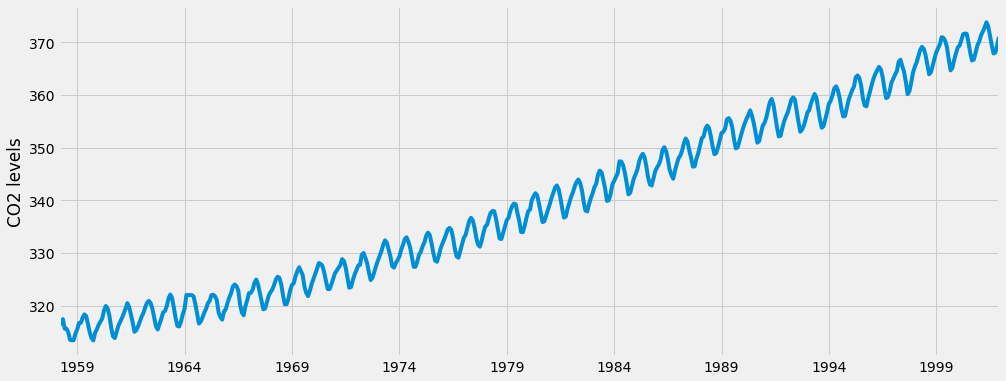

In [6]:
y.plot(figsize=(15, 6))
plt.ylabel('CO2 levels')
plt.show()

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">`statsmodels.graphics.tsaplots.plot_pacf`</a>`(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, **kwargs)`

`x` --- временной ряд

`lags` --- количество лагов

`ax` --- фигура `matplotlib`

`alpha` --- уровень доверия для доверительных интервалов

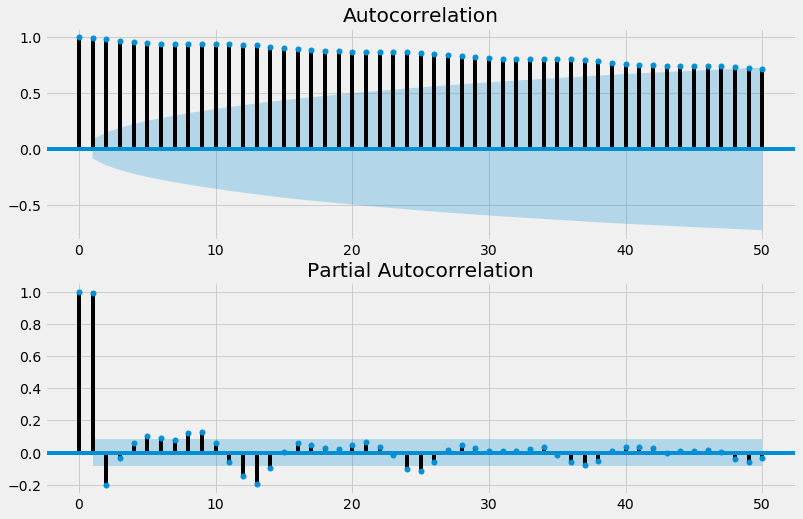

In [7]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y, lags=50, ax=ax2)
plt.show()

Ничего хорошего не выходит.

В данных явно есть линейный тренд.
Продифференцируем ряд и изобразим график полученного ряда.

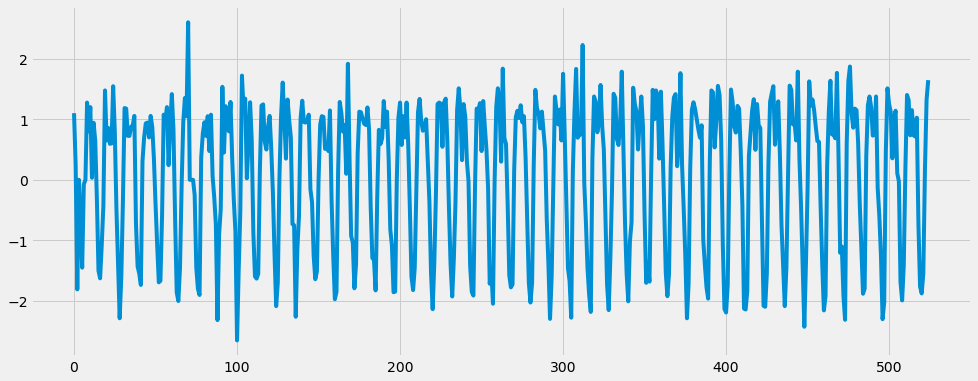

In [8]:
ya = np.array(y)
yt = ya[1:] - ya[:-1]  # дифференцирование

plt.figure(figsize=(15, 6))
plt.plot(yt)
plt.show()

Отлично, тренд сняли.

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) для продифференцированного ряда.

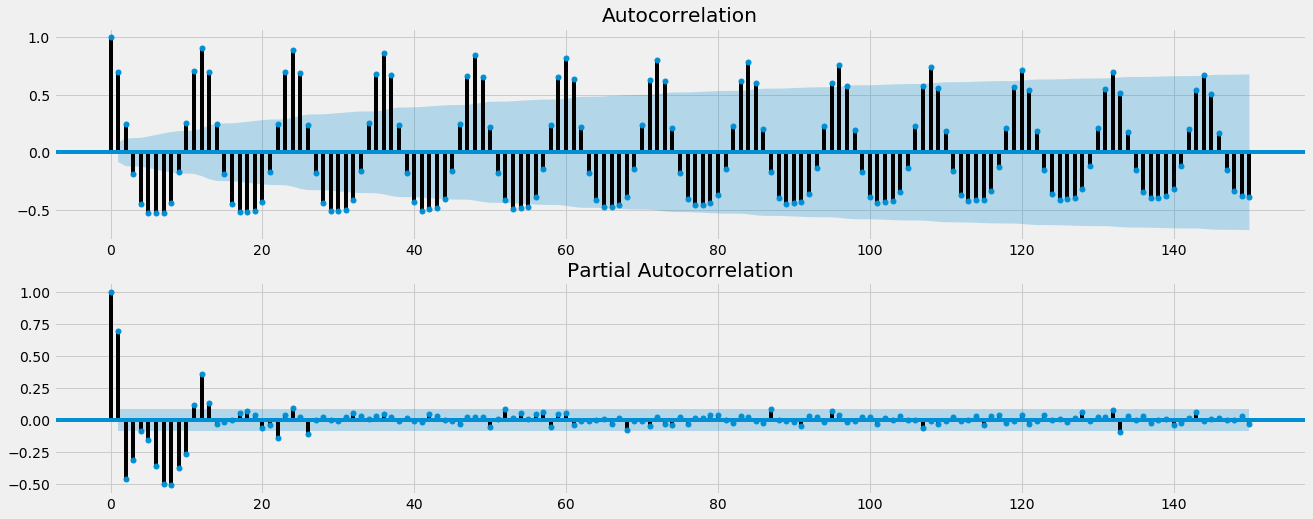

In [9]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yt, lags=150, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yt, lags=150, ax=ax2)
plt.show()

Как график продифференцированного ряда, так и его автокорреляционная функция намекают на сезонность.

Применим сезонное дифференцирование.
Период сезонности известен заранее --- 12 месяцев.

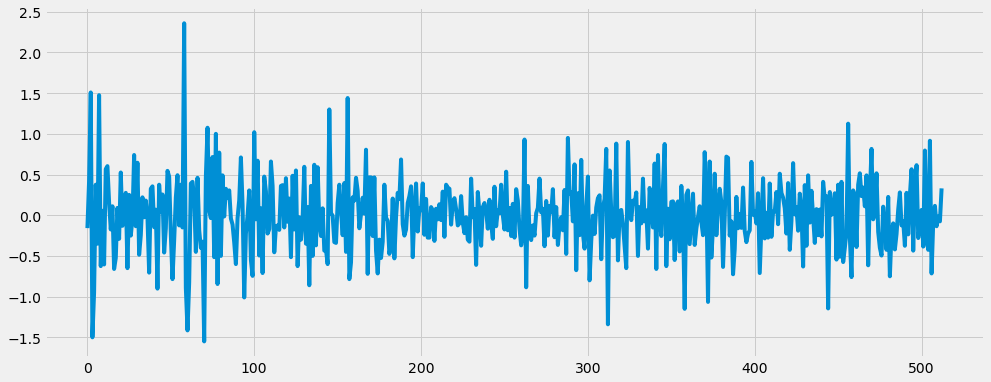

In [10]:
yts = yt[12:] - yt[:-12]

plt.figure(figsize=(15, 6))
plt.plot(yts)
plt.show()

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) после первого дифференцирования и последующего сезонного дифференцирования.

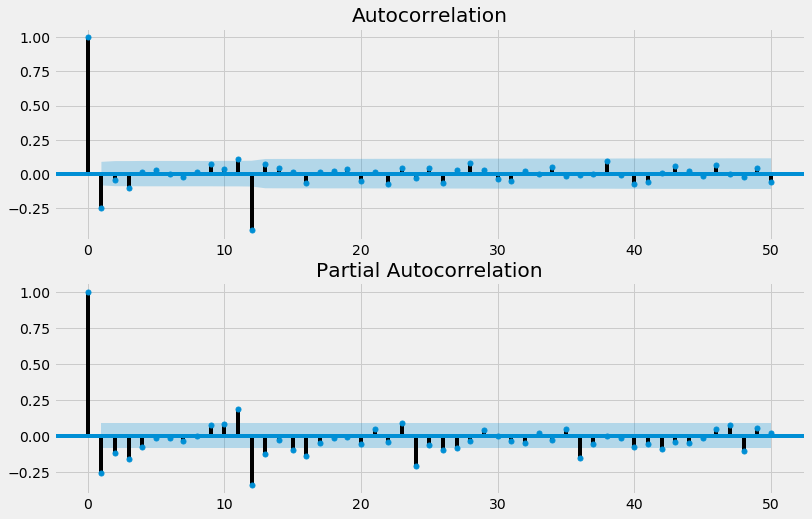

In [11]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(yts, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(yts, lags=50, ax=ax2)
plt.show()

По графикам видно несколько значимых лагов в начале, а так же значимые лаги через периоды сезонности. При выборе пилотных $p$ и $q$ лаги через периоды сезонности учитывать не стоит, поскольку эти зависимости модель учтет с помощью сезонных компонент --- сезонным дифференцированием могла "сняться" не вся сезонность 

В общем-то просто сделаем полный перебор по всем небольшим параметрам.

In [16]:
p = range(3)
q = range(5)
d = [1]
P = range(4)
D = [1]
Q = range(3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(P, D, Q))]

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

`endog` --- временной ряд

`exog` --- экзогенные факторы (регрессоры)

`order` = $(p, d, q)$

`seasonal_order` = $(P, D, Q, s)$

Метод `fit` --- обучение модели (оценка коэффициентов).

Если не работает `tqdm_notebook`, замените на `tqdm` или просто уберите его.

In [17]:
warnings.filterwarnings('ignore')

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, 
                                              enforce_stationarity=False, enforce_invertibility=False)
            model = model.fit()
            print('ARIMA{}x{}12 – AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 – AIC:337.79385490535475
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 – AIC:315.3783166725257
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 – AIC:478.3296906672489
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 – AIC:323.32458649586164
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 – AIC:315.4739955034589
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 – AIC:416.5149151120175
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 – AIC:322.76670988711606
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 – AIC:319.6161981657093
ARIMA(0, 1, 0)x(3, 1, 0, 12)12 – AIC:387.75787721853527
ARIMA(0, 1, 0)x(3, 1, 1, 12)12 – AIC:322.14589357102363
ARIMA(0, 1, 0)x(3, 1, 2, 12)12 – AIC:310.15781725788173


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 – AIC:587.9479709744935
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 – AIC:302.4949002863983
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 – AIC:275.49906520280075
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 – AIC:433.0863608210692
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 – AIC:281.51901830638747
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 – AIC:275.611262524969
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 – AIC:359.8933966779248
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 – AIC:282.9833293356515
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 – AIC:279.2233238034976
ARIMA(0, 1, 1)x(3, 1, 0, 12)12 – AIC:334.86091430038624
ARIMA(0, 1, 1)x(3, 1, 1, 12)12 – AIC:281.74686708636114
ARIMA(0, 1, 1)x(3, 1, 2, 12)12 – AIC:271.4561709553138


ARIMA(0, 1, 2)x(0, 1, 0, 12)12 – AIC:568.712924037336
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 – AIC:296.1523476661643
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 – AIC:273.3519469796003
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 – AIC:431.9316622082579
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 – AIC:279.8705828862576
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 – AIC:274.42510939338445
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 – AIC:357.7214994298906
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 – AIC:280.96864062148813
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 – AIC:276.9930099776567
ARIMA(0, 1, 2)x(3, 1, 0, 12)12 – AIC:332.2441844669206
ARIMA(0, 1, 2)x(3, 1, 1, 12)12 – AIC:280.370480621415
ARIMA(0, 1, 2)x(3, 1, 2, 12)12 – AIC:271.0465246134793


ARIMA(0, 1, 3)x(0, 1, 0, 12)12 – AIC:560.8599804476833
ARIMA(0, 1, 3)x(0, 1, 1, 12)12 – AIC:293.5749227718708
ARIMA(0, 1, 3)x(0, 1, 2, 12)12 – AIC:273.5522460482489
ARIMA(0, 1, 3)x(1, 1, 0, 12)12 – AIC:429.9035623887418
ARIMA(0, 1, 3)x(1, 1, 1, 12)12 – AIC:279.1145053492326
ARIMA(0, 1, 3)x(1, 1, 2, 12)12 – AIC:274.15911141087673
ARIMA(0, 1, 3)x(2, 1, 0, 12)12 – AIC:358.95522880387875
ARIMA(0, 1, 3)x(2, 1, 1, 12)12 – AIC:280.67598742545977
ARIMA(0, 1, 3)x(2, 1, 2, 12)12 – AIC:276.600771109753
ARIMA(0, 1, 3)x(3, 1, 0, 12)12 – AIC:333.00493211191684
ARIMA(0, 1, 3)x(3, 1, 1, 12)12 – AIC:280.2656782545022
ARIMA(0, 1, 3)x(3, 1, 2, 12)12 – AIC:271.2721449975996


ARIMA(0, 1, 4)x(0, 1, 0, 12)12 – AIC:554.8575753185976
ARIMA(0, 1, 4)x(0, 1, 1, 12)12 – AIC:280.44175440656005
ARIMA(0, 1, 4)x(0, 1, 2, 12)12 – AIC:274.7426643927667
ARIMA(0, 1, 4)x(1, 1, 0, 12)12 – AIC:431.51013886800206
ARIMA(0, 1, 4)x(1, 1, 1, 12)12 – AIC:277.61264221606245
ARIMA(0, 1, 4)x(1, 1, 2, 12)12 – AIC:276.3968789205647
ARIMA(0, 1, 4)x(2, 1, 0, 12)12 – AIC:359.68475343972983
ARIMA(0, 1, 4)x(2, 1, 1, 12)12 – AIC:282.66875996616045
ARIMA(0, 1, 4)x(2, 1, 2, 12)12 – AIC:277.2433178893567
ARIMA(0, 1, 4)x(3, 1, 0, 12)12 – AIC:334.6891350565296
ARIMA(0, 1, 4)x(3, 1, 1, 12)12 – AIC:282.2445684350317
ARIMA(0, 1, 4)x(3, 1, 2, 12)12 – AIC:272.95804730563697


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 – AIC:600.7412682874252
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 – AIC:312.1329632361338
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 – AIC:283.6106681511658
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 – AIC:440.1375884358338
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 – AIC:293.5614536112339
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 – AIC:284.40487894327174
ARIMA(1, 1, 0)x(2, 1, 0, 12)12 – AIC:374.9066287308649
ARIMA(1, 1, 0)x(2, 1, 1, 12)12 – AIC:289.9107329309427
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 – AIC:288.80059620304917
ARIMA(1, 1, 0)x(3, 1, 0, 12)12 – AIC:348.9917085626
ARIMA(1, 1, 0)x(3, 1, 1, 12)12 – AIC:290.5888616768718
ARIMA(1, 1, 0)x(3, 1, 2, 12)12 – AIC:277.2618980146656


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 – AIC:581.3099935252751
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 – AIC:295.9374059406814
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 – AIC:272.2101594313544
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 – AIC:444.12436865154666
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 – AIC:277.7802202870399
ARIMA(1, 1, 1)x(1, 1, 2, 12)12 – AIC:272.5312608622793
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 – AIC:356.77336576364615
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 – AIC:277.0724219799703
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 – AIC:275.6744948507642
ARIMA(1, 1, 1)x(3, 1, 0, 12)12 – AIC:331.2995157119235
ARIMA(1, 1, 1)x(3, 1, 1, 12)12 – AIC:278.9650074657301
ARIMA(1, 1, 1)x(3, 1, 2, 12)12 – AIC:268.0016984320621


ARIMA(1, 1, 2)x(0, 1, 0, 12)12 – AIC:568.8958761969552
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 – AIC:295.74088580938667
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 – AIC:272.94034355042265
ARIMA(1, 1, 2)x(1, 1, 0, 12)12 – AIC:430.29968015177803
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 – AIC:278.9864252503438
ARIMA(1, 1, 2)x(1, 1, 2, 12)12 – AIC:273.6242805519623
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 – AIC:358.7597033178493
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 – AIC:278.8267747100424
ARIMA(1, 1, 2)x(2, 1, 2, 12)12 – AIC:277.3139305634046
ARIMA(1, 1, 2)x(3, 1, 0, 12)12 – AIC:333.28835767105653
ARIMA(1, 1, 2)x(3, 1, 1, 12)12 – AIC:280.6914702925261
ARIMA(1, 1, 2)x(3, 1, 2, 12)12 – AIC:267.234634615408


ARIMA(1, 1, 3)x(0, 1, 0, 12)12 – AIC:562.5496193401232
ARIMA(1, 1, 3)x(0, 1, 1, 12)12 – AIC:295.4869876528658
ARIMA(1, 1, 3)x(0, 1, 2, 12)12 – AIC:275.4163461328269
ARIMA(1, 1, 3)x(1, 1, 0, 12)12 – AIC:429.771464409848
ARIMA(1, 1, 3)x(1, 1, 1, 12)12 – AIC:280.57551836071
ARIMA(1, 1, 3)x(1, 1, 2, 12)12 – AIC:276.0540685434322
ARIMA(1, 1, 3)x(2, 1, 0, 12)12 – AIC:359.75365202442015
ARIMA(1, 1, 3)x(2, 1, 1, 12)12 – AIC:280.21308118496756
ARIMA(1, 1, 3)x(2, 1, 2, 12)12 – AIC:278.57226297507316
ARIMA(1, 1, 3)x(3, 1, 0, 12)12 – AIC:334.5566624289189
ARIMA(1, 1, 3)x(3, 1, 1, 12)12 – AIC:282.0690173731866
ARIMA(1, 1, 3)x(3, 1, 2, 12)12 – AIC:271.01192655026654


ARIMA(1, 1, 4)x(0, 1, 0, 12)12 – AIC:555.9533905171842
ARIMA(1, 1, 4)x(0, 1, 1, 12)12 – AIC:279.4159930358892
ARIMA(1, 1, 4)x(0, 1, 2, 12)12 – AIC:276.5648129886704
ARIMA(1, 1, 4)x(1, 1, 0, 12)12 – AIC:430.9357217693942
ARIMA(1, 1, 4)x(1, 1, 1, 12)12 – AIC:276.93044084382035
ARIMA(1, 1, 4)x(1, 1, 2, 12)12 – AIC:277.82523366231277
ARIMA(1, 1, 4)x(2, 1, 0, 12)12 – AIC:360.50035494160215
ARIMA(1, 1, 4)x(2, 1, 1, 12)12 – AIC:282.1361364768684
ARIMA(1, 1, 4)x(2, 1, 2, 12)12 – AIC:278.723079150322
ARIMA(1, 1, 4)x(3, 1, 0, 12)12 – AIC:335.9720287345401
ARIMA(1, 1, 4)x(3, 1, 1, 12)12 – AIC:284.06693687828204
ARIMA(1, 1, 4)x(3, 1, 2, 12)12 – AIC:271.0140617935431


ARIMA(2, 1, 0)x(0, 1, 0, 12)12 – AIC:594.3524956552991
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 – AIC:308.6009634239319
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 – AIC:279.31322584328245
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 – AIC:436.05546017009965
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 – AIC:288.9646785066267
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 – AIC:281.65250455781035
ARIMA(2, 1, 0)x(2, 1, 0, 12)12 – AIC:365.425248045324
ARIMA(2, 1, 0)x(2, 1, 1, 12)12 – AIC:285.1376938575727
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 – AIC:284.1212544319757
ARIMA(2, 1, 0)x(3, 1, 0, 12)12 – AIC:339.7736521814195
ARIMA(2, 1, 0)x(3, 1, 1, 12)12 – AIC:283.7660442384409
ARIMA(2, 1, 0)x(3, 1, 2, 12)12 – AIC:271.43693112583804


ARIMA(2, 1, 1)x(0, 1, 0, 12)12 – AIC:569.1491462061952
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 – AIC:298.35998315649084
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 – AIC:273.73153804276103
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 – AIC:426.1422065102088
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 – AIC:281.63283709303886
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 – AIC:273.49568075244827
ARIMA(2, 1, 1)x(2, 1, 0, 12)12 – AIC:363.6170954945263
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 – AIC:278.5892510025552
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 – AIC:275.4815783386255
ARIMA(2, 1, 1)x(3, 1, 0, 12)12 – AIC:331.92143586605005
ARIMA(2, 1, 1)x(3, 1, 1, 12)12 – AIC:277.9282443933931
ARIMA(2, 1, 1)x(3, 1, 2, 12)12 – AIC:265.8784634293445


ARIMA(2, 1, 2)x(0, 1, 0, 12)12 – AIC:570.0680233612488
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 – AIC:295.70657634133227
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 – AIC:274.5760356961192
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 – AIC:428.7597018173051
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 – AIC:281.4747326696527
ARIMA(2, 1, 2)x(1, 1, 2, 12)12 – AIC:275.3028456868903
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 – AIC:359.71792559384653
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 – AIC:280.2681378366182
ARIMA(2, 1, 2)x(2, 1, 2, 12)12 – AIC:278.8696807209192
ARIMA(2, 1, 2)x(3, 1, 0, 12)12 – AIC:333.6392064679911
ARIMA(2, 1, 2)x(3, 1, 1, 12)12 – AIC:279.5545738280767
ARIMA(2, 1, 2)x(3, 1, 2, 12)12 – AIC:268.7102754174051


ARIMA(2, 1, 3)x(0, 1, 0, 12)12 – AIC:563.7729184332263
ARIMA(2, 1, 3)x(0, 1, 1, 12)12 – AIC:291.0282181329723
ARIMA(2, 1, 3)x(0, 1, 2, 12)12 – AIC:277.264715434286
ARIMA(2, 1, 3)x(1, 1, 0, 12)12 – AIC:430.06041003709225
ARIMA(2, 1, 3)x(1, 1, 1, 12)12 – AIC:283.023311573916
ARIMA(2, 1, 3)x(1, 1, 2, 12)12 – AIC:278.00735877435517
ARIMA(2, 1, 3)x(2, 1, 0, 12)12 – AIC:348.78435896239387
ARIMA(2, 1, 3)x(2, 1, 1, 12)12 – AIC:282.04257284572714
ARIMA(2, 1, 3)x(2, 1, 2, 12)12 – AIC:280.55670600026576
ARIMA(2, 1, 3)x(3, 1, 0, 12)12 – AIC:335.0858906729859
ARIMA(2, 1, 3)x(3, 1, 1, 12)12 – AIC:281.3813096845216
ARIMA(2, 1, 3)x(3, 1, 2, 12)12 – AIC:270.72507584295715


ARIMA(2, 1, 4)x(0, 1, 0, 12)12 – AIC:542.0251828334442
ARIMA(2, 1, 4)x(0, 1, 1, 12)12 – AIC:282.34464927706733
ARIMA(2, 1, 4)x(0, 1, 2, 12)12 – AIC:279.14941535321714
ARIMA(2, 1, 4)x(1, 1, 0, 12)12 – AIC:432.182934092477
ARIMA(2, 1, 4)x(1, 1, 1, 12)12 – AIC:279.0255821234206
ARIMA(2, 1, 4)x(1, 1, 2, 12)12 – AIC:280.32645318967303
ARIMA(2, 1, 4)x(2, 1, 0, 12)12 – AIC:362.7751636267467
ARIMA(2, 1, 4)x(2, 1, 1, 12)12 – AIC:283.8492166013215
ARIMA(2, 1, 4)x(2, 1, 2, 12)12 – AIC:280.77559776987033
ARIMA(2, 1, 4)x(3, 1, 0, 12)12 – AIC:337.0941853250491
ARIMA(2, 1, 4)x(3, 1, 1, 12)12 – AIC:283.4382027694419
ARIMA(2, 1, 4)x(3, 1, 2, 12)12 – AIC:271.60449485472054



Оптимальной является модель
`ARIMA(2, 1, 1)x(3, 1, 2, 12)12 – AIC:265.8784634293445`.

Обучим эту модель и выведем некоторе статистические свойства

In [18]:
model = sm.tsa.statespace.SARIMAX(y, order=(2, 1, 1), seasonal_order=(3, 1, 2, 12),
                                enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4671      0.053      8.820      0.000       0.363       0.571
ar.L2          0.1170      0.045      2.610      0.009       0.029       0.205
ma.L1         -0.7847      0.042    -18.478      0.000      -0.868      -0.701
ar.S.L12      -0.8472      0.061    -13.793      0.000      -0.968      -0.727
ar.S.L24      -0.0710      0.079     -0.898      0.369      -0.226       0.084
ar.S.L36      -0.0716      0.050     -1.426      0.154      -0.170       0.027
ma.S.L12       0.0234      0.061      0.385      0.700      -0.096       0.142
ma.S.L24      -0.7693      0.053    -14.631      0.000      -0.872      -0.666
sigma2         0.0943      0.006     16.859      0.000       0.083       0.105


В первом столбце выписаны названия коэффициентов. Например, `ar.L2` --- название коэффициента перед второй авторегрессионной компонентой, то есть перед $y_{t-2}$; а `ma.S.L12` --- название коэффициента перед первой сезонной компонентой модели скользящего среднего, то есть перед $\varepsilon_{t-12}$.

Второй и третий столбцы (`coef` и `std err`) --- оценки коэффициента и стандартного отклонения.

Четвертый и пятый столбцы отвечают проверке гипотезы о значимости коэффициента ($H_0$: коэффициент равен 0 $vs. H_1$: коэффициент не равен 0; см. линейные гипотезы в гауссовской модели).
Столбец `z` --- значение статистики критерия, столбец `P>|z|` --- p-value критерия.
Можно заметить, что гипотеза о незначимости коэффициента не отвергается для коэффициентов `ar.S.L24`, `ar.S.L36` и `ma.S.L12`.

Последние два столбца отвечают за 95%-доверительный интервал. Можно заметить, что доверительный интервал содержит 0 только для незначимых коэффициентов.

--------------------

Полная таблица статсвойств

In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(2, 1, 1)x(3, 1, 2, 12)   Log Likelihood                -123.939
Date:                            Mon, 20 Nov 2017   AIC                            265.878
Time:                                    03:35:07   BIC                            304.266
Sample:                                03-01-1958   HQIC                           280.909
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4671      0.053      8.820      0.000       0.363       0.571
ar.L2          0.1170      0.045      2.610      0.009       0.029       0.205
ma.L1         -0.7847      0.042    -18.478      0.000      -0.868      -0.701
ar.S.L12      -0.8472      0.061    -13.793      0.000      -0.968      -0.727
ar.S.L24      -0.0710      0.079     -0.898      0.369      -0.226       0.084
ar.S.L36      -0.0716      0.050     -1.426      0.154      -0.170       0.027
ma.S.L12       0.0234      0.061      0.385      0.700      -0.096       0.142
ma.S.L24      -0.7693      0.053    -14.631      0.000      -0.872      -0.666
sigma2         0.0943      0.006     16.859      0.000       0.083       0.105
===================================================================================
Ljung-Box (Q):                       31.92   Jarque-Bera (JB):                43.21
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.19
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

В последней таблице приведены значения статистик и pvalue для критериев Льюнга-Бокса (автокоррелированность), проверки на гомоскедастичность и критерий Жарка-Бера (нормальность). Кроме того, приведены значения коэффициентов ассиметрии и эксцесса.

--------------------

Не забываем про бикини --- нужно всегда смотреть на графики.
Метод `plot_diagnostics` позволяет быстро сделать диагностику модели и исследовать любое необычное поведение.

Первый график --- график остатков модели.
На следующем графике (верхний правый) изображена гистограмма для остатков, ядерная оценка плостности и плотность стандартного нормального распределения.
Третий график Q-Q plot (квантиль-квантиль график) служит для визуальной проверки нормальности. По горизонтальной оси откладываются теоретические квантили, а по вертикальной --- соответствующие выборочные квантили. Данные согласуются с нормальным распределением, если точки расположены вдоль некоторой прямой.

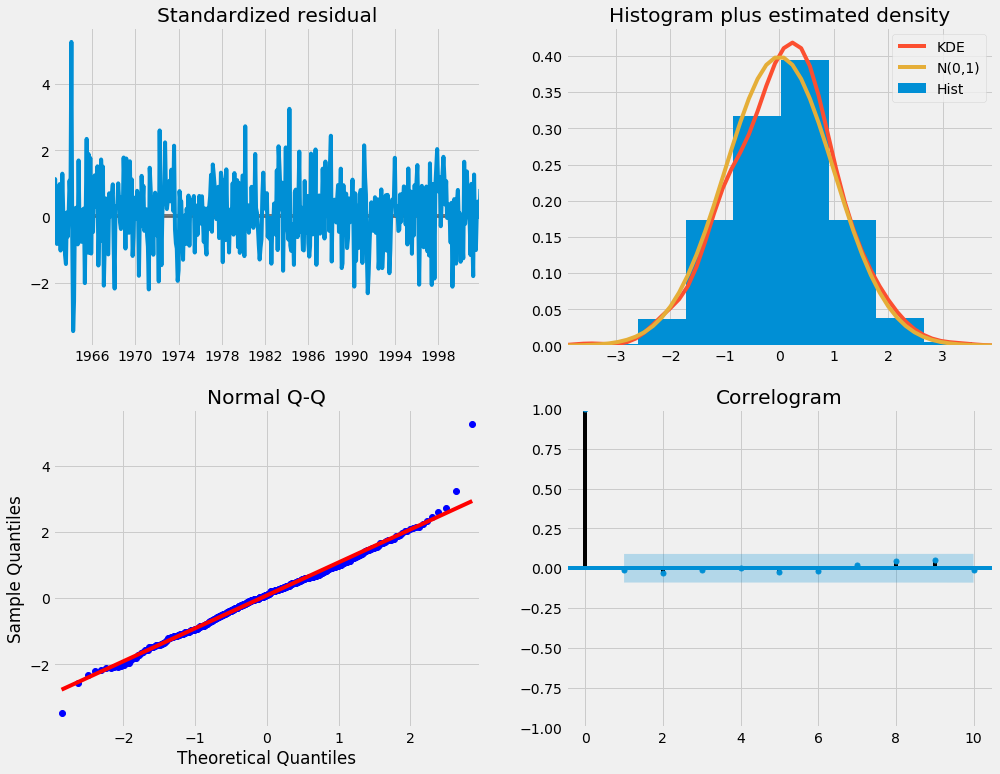

In [20]:
model.plot_diagnostics(figsize=(15, 12))
plt.show()

### Прогнозирование

Начнем с сравнения прогнозируемых значений с реальными значениями временного ряда, чтобы понять насколько точны наши прогнозы.

`get_prediction` и `conf_int` позволяют нам получать значения и связанные с ними доверительные интервалы для дальнейших прогнозов временных рядов.

В коде мы указали чтобы прогнозы начинались с января 1998 года.

Параметр `dynamic = False` гарантирует, что мы создаем прогнозы на один шаг вперед, а это означает, что прогнозы в каждой точке генерируются с использованием полной истории, вплоть до этой точки.

In [ ]:
pred = model.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

Построим график значений временного ряда CO2, чтобы увидеть наши результаты. 

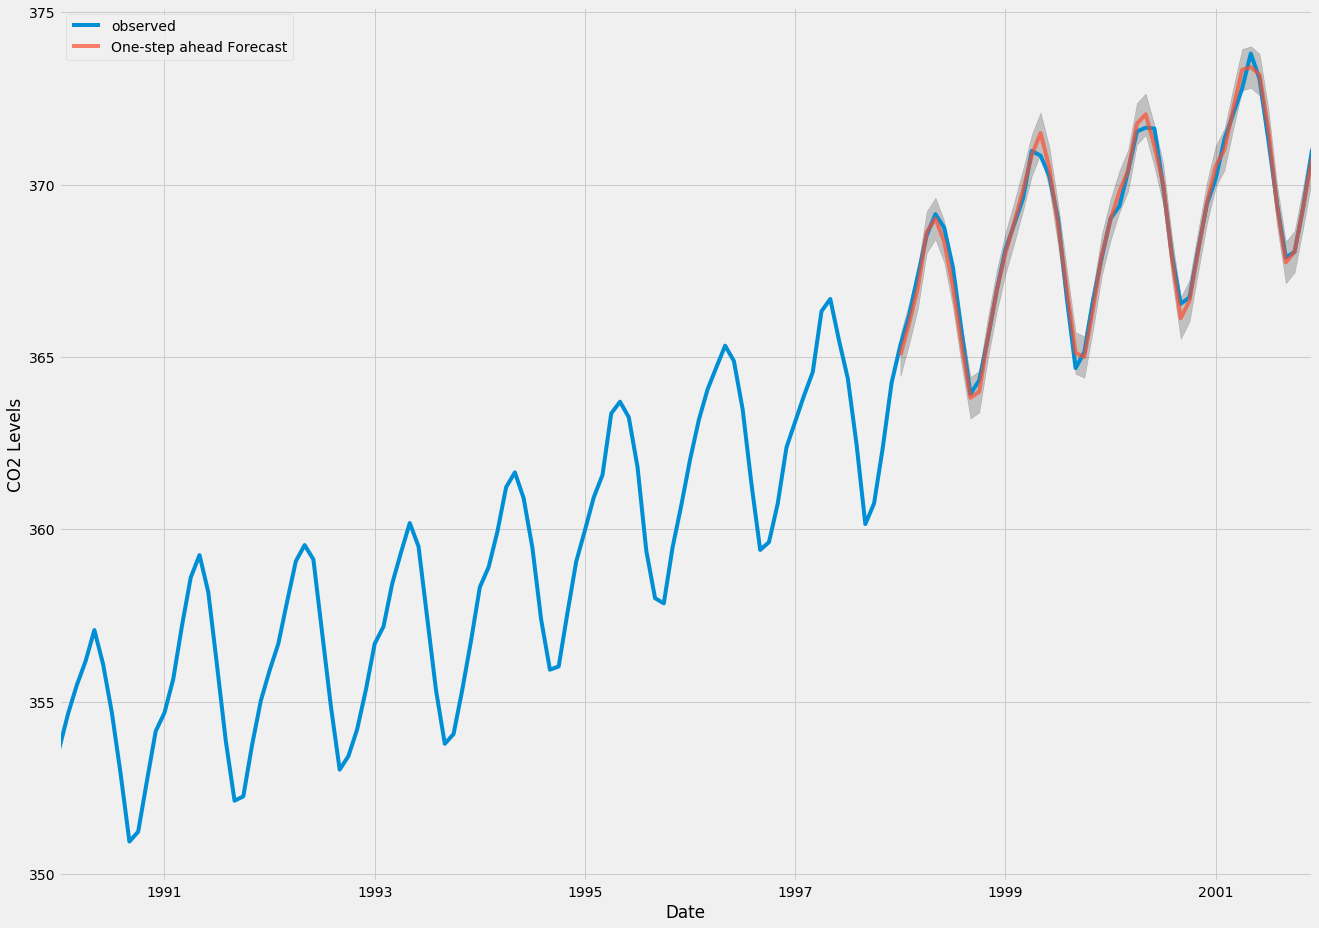

In [22]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

Посчитаем MSE

In [23]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.08


Динамические прогнозы.

В этом случае мы используем только информацию из временных рядов до определенной точки, а затем прогнозы генерируются с использованием значений из предыдущих прогнозируемых временных точек.

В данном коде мы используем именно динамическое прогнозирование и начинаем с января 1998:

In [24]:
pred_dynamic = model.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

Построим график

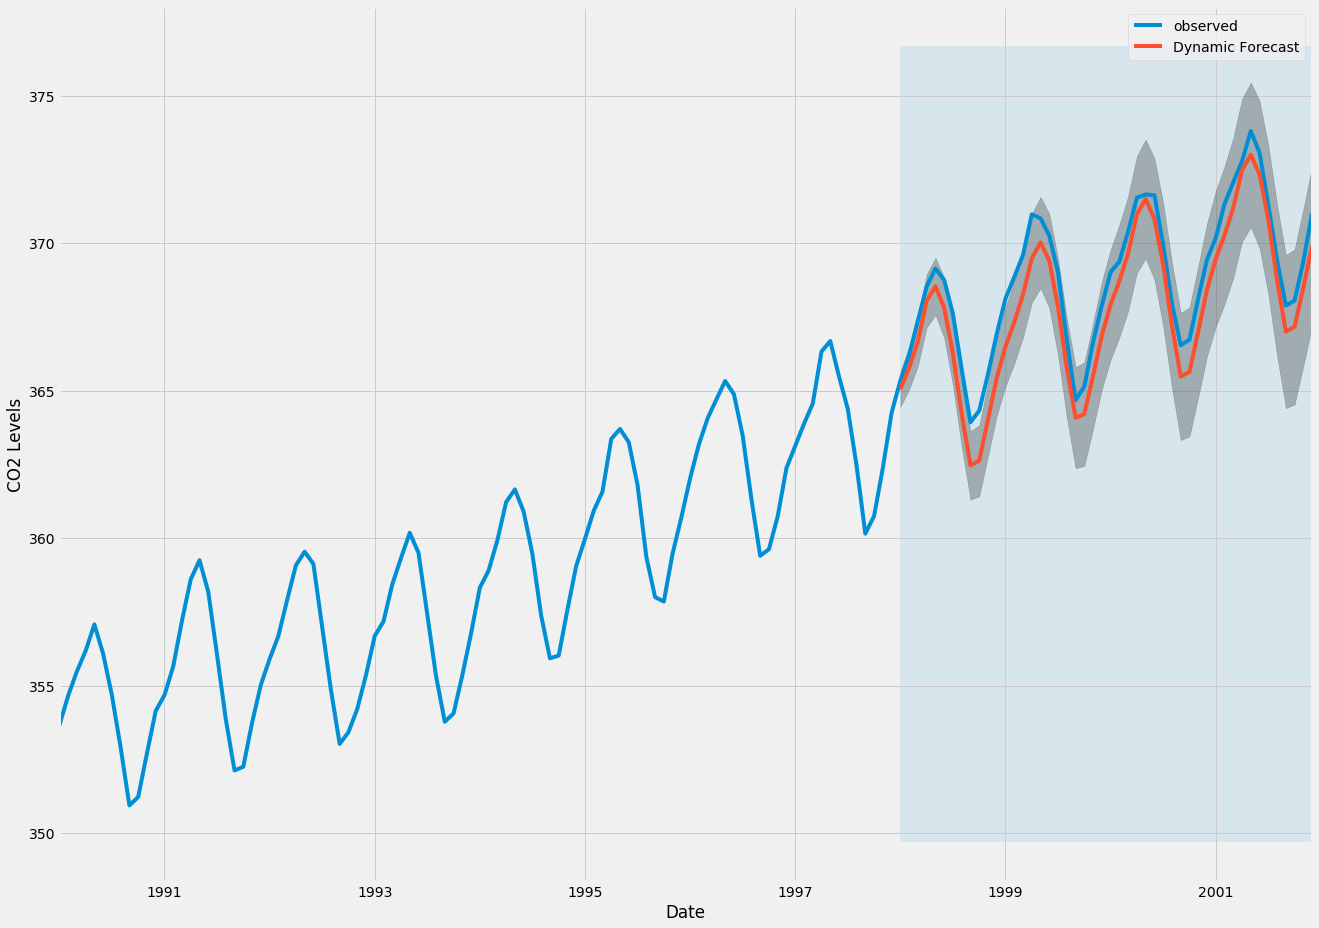

In [25]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1], alpha=.1, zorder=-1)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

Посчитаем MSE

In [26]:
# извлекаем прогнозированные и верные значения нашего временного ряда
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]
# вычисляем среднеквадратичную ошибку
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.02


Прогноз на далекое будущее (500 месяцев)

In [27]:
# прогноз на 500 шагов
pred_uc = model.get_forecast(steps=500)
# доверительные интервалы
pred_ci = pred_uc.conf_int()

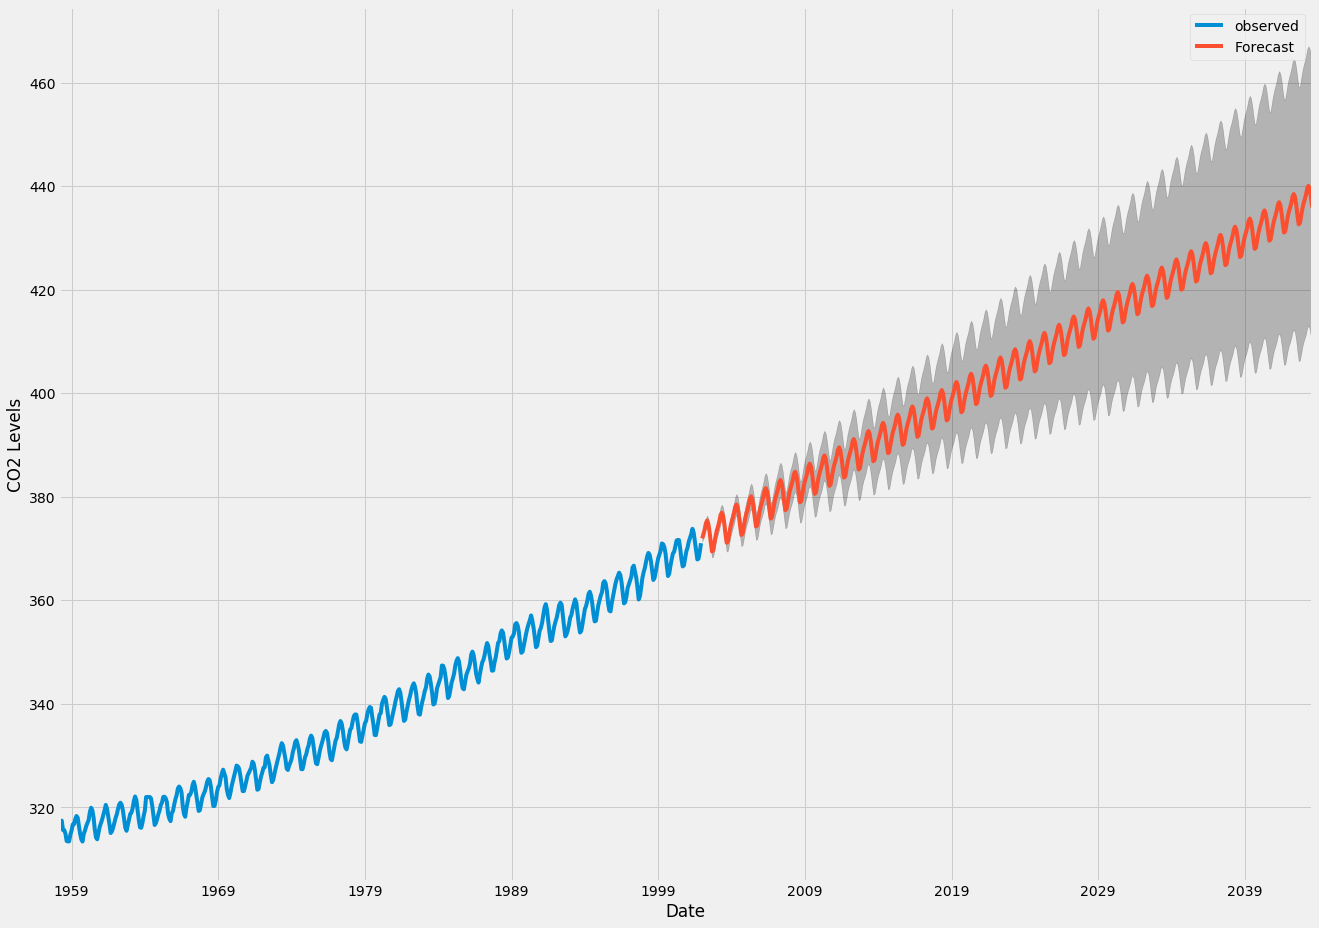

In [28]:
ax = y.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()